Chargement et prétraitement des données & division des données en ensembles d'entraînement et de test

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# Charger le fichier contenant toutes les images et leurs labels
full_data = pd.read_csv("./data/Training_set.csv")

# Séparer 20% pour le train et 80% pour le test
train_data, test_data = train_test_split(full_data, test_size=0.8, random_state=42, stratify=full_data["label"])

# Supprimer la colonne 'label' du test pour ne garder que les images
test_data = test_data.drop(columns=["label"])

# Sauvegarde des fichiers CSV
train_data.to_csv("./data/Train_split.csv", index=False)  # Contient images + labels
test_data.to_csv("./data/Test_split.csv", index=False)  # Contient seulement les images (sans labels)

# Vérifier la répartition
print(f"Nombre d'images d'entraînement : {len(train_data)}")
print(f"Nombre d'images de test : {len(test_data)}")  # Sans labels !

Nombre d'images d'entraînement : 1299
Nombre d'images de test : 5200


Nettoyage de Test_split.csv pour correspondre avec le dossier d'image test

In [4]:
# Charger le CSV contenant les images de test
test_df = pd.read_csv("./data/Test_split.csv")

# Vérifier la liste des fichiers réellement présents dans le dossier /test/
test_images_folder = "./data/test/"
existing_images = set(os.listdir(test_images_folder))  # Ensemble contenant les fichiers disponibles

# Vérifier combien d'images dans Test_split.csv n'existent pas
missing_images = [img for img in test_df["filename"] if img not in existing_images]

print(f"Nombre d'images manquantes : {len(missing_images)}")

# Filtrer pour ne garder que les images qui existent vraiment
clean_test_df = test_df[test_df["filename"].isin(existing_images)]

# Sauvegarder le fichier nettoyé
clean_test_df.to_csv("./data/Test_split_cleaned.csv", index=False)

print(f"Nouveau fichier créé : {len(clean_test_df)} images valides dans 'Test_split_cleaned.csv'")


Nombre d'images manquantes : 2963
Nouveau fichier créé : 2237 images valides dans 'Test_split_cleaned.csv'


Définition du DataSet pour entrainement (avec labels)

In [5]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image


# Définition des transformations d'image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize([0.5], [0.5])  
])

# Dataset d'entraînement (avec labels)
class ButterflyTrainDataset(Dataset):
    def __init__(self, csv_file, root_dir, class_mapping, transform=None):
        self.data = pd.read_csv(csv_file)  
        self.root_dir = root_dir  
        self.class_mapping = class_mapping  
        self.transform = transform  

    def __len__(self):
        return len(self.data)  

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])  
        image = Image.open(img_name).convert('RGB')  
        label = self.class_mapping[self.data.iloc[idx, 1]]  

        if self.transform:
            image = self.transform(image)  

        return image, label


Définition du DataSet pour le test (sans labels)

In [6]:
# Dataset de test (sans labels)
class ButterflyTestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)  
        self.root_dir = root_dir  
        self.transform = transform  

    def __len__(self):
        return len(self.data)  

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])  
        image = Image.open(img_name).convert('RGB')  

        if self.transform:
            image = self.transform(image)  

        return image  

Appel des Dataset (Liason entre les images et les .csv) & DataLoader

In [7]:
from torch.utils.data import DataLoader

# Création d'un dictionnaire label → ID
class_mapping = {label: idx for idx, label in enumerate(train_data["label"].unique())}

# Création des datasets
train_dataset = ButterflyTrainDataset("./data/Train_split.csv", "./data/train", class_mapping, transform=transform)
test_dataset = ButterflyTestDataset("./data/Test_split_cleaned.csv", "./data/test", transform=transform)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  

# Vérifier la répartition
print(f"Nombre d'images d'entraînement : {len(train_dataset)}")
print(f"Nombre d'images de test : {len(test_dataset)}")

Nombre d'images d'entraînement : 1299
Nombre d'images de test : 2237


Définir un modèle CNN

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class ButterflyClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ButterflyClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Détecter le nombre de classes automatiquement
num_classes = len(class_mapping)
model = ButterflyClassifier(num_classes)

In [9]:
#Fonction de perte et optimiseur
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Perte pour la classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimiseur Adam


Entrainement du modèle / Evaluation du modèle / Sauvegarde du modèle avec la meilleure Accuracy

In [11]:
best_accuracy = 0.0

num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Entraînement sur train_loader
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Évaluation sur train_loader pour calculer l'accuracy
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100  # Calcul de l'accuracy en pourcentage

    print(f" Epoch {epoch+1}/{num_epochs} : Average Loss = {running_loss / len(train_loader)}, Accuracy = {accuracy:.2f}%")

    # Sauvegarder le meilleur modèle
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best_butterfly_model.pth")
        print(f"✅ Nouveau meilleur modèle sauvegardé avec Accuracy = {accuracy:.2f}%")

 Epoch 1/20 : Average Loss = 2.869132332685517, Accuracy = 60.43%
✅ Nouveau meilleur modèle sauvegardé avec Accuracy = 60.43%
 Epoch 2/20 : Average Loss = 2.3187879033204988, Accuracy = 72.83%
✅ Nouveau meilleur modèle sauvegardé avec Accuracy = 72.83%
 Epoch 3/20 : Average Loss = 1.8810684506486102, Accuracy = 85.45%
✅ Nouveau meilleur modèle sauvegardé avec Accuracy = 85.45%
 Epoch 4/20 : Average Loss = 1.4451208187312614, Accuracy = 90.69%
✅ Nouveau meilleur modèle sauvegardé avec Accuracy = 90.69%
 Epoch 5/20 : Average Loss = 1.1859006053063927, Accuracy = 93.69%
✅ Nouveau meilleur modèle sauvegardé avec Accuracy = 93.69%
 Epoch 6/20 : Average Loss = 0.9559031579552627, Accuracy = 95.23%
✅ Nouveau meilleur modèle sauvegardé avec Accuracy = 95.23%
 Epoch 7/20 : Average Loss = 0.8610566411076522, Accuracy = 96.77%
✅ Nouveau meilleur modèle sauvegardé avec Accuracy = 96.77%
 Epoch 8/20 : Average Loss = 0.785415289968979, Accuracy = 97.23%
✅ Nouveau meilleur modèle sauvegardé avec Accu

Evaluation du modèle

In [12]:
# Charger le meilleur modèle entraîné
model.load_state_dict(torch.load("best_butterfly_model.pth"))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\Léa\AppData\Local\Temp\ipykernel_2752\2274808044.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_butterfly_model.pth"))


ButterflyClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=75, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Teste du modèle sur l'ensemble de test

In [13]:
# On passe les images de test au modèle et on récupère les classes prédites
import numpy as np

predictions = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)  # Obtenir les prédictions
        _, predicted = torch.max(outputs, 1)  # Prendre la classe la plus probable
        predictions.extend(predicted.cpu().numpy())  # Convertir en liste


In [14]:
# Inverser le dictionnaire class_mapping (ID → Nom de classe)
inverse_class_mapping = {v: k for k, v in class_mapping.items()}

# Convertir les prédictions en noms de classes
predictions_text = [inverse_class_mapping[p] for p in predictions]

In [15]:
# Charger la liste des noms des fichiers test
test_filenames = pd.read_csv("./data/Test_split_cleaned.csv")["filename"]

# Créer un DataFrame avec les prédictions
submission_df = pd.DataFrame({"filename": test_filenames, "predicted_label": predictions_text})

# Sauvegarder dans un fichier CSV
submission_df.to_csv("./data/Predictions.csv", index=False)

print("Prédictions enregistrées dans 'Predictions.csv' !")

Prédictions enregistrées dans 'Predictions.csv' !


Afficher les images avec le label prédit

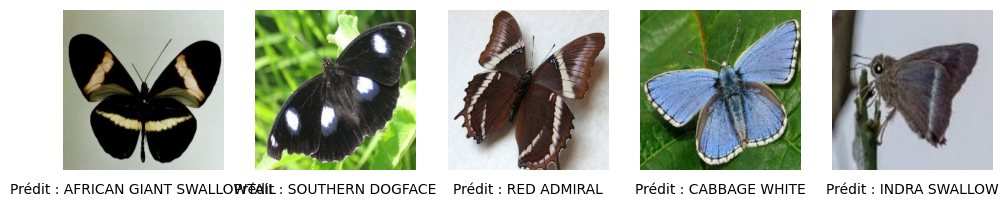

In [17]:
import matplotlib.pyplot as plt
from PIL import Image

predictions_df = pd.read_csv("./data/Predictions.csv")

num_images = 5  

# Charger les 5 premières lignes
sample_images = predictions_df.head(num_images)

# Afficher les images avec leur label prédit
plt.figure(figsize=(12,6))

for i, row in enumerate(sample_images.itertuples(), 1):
    img_path = os.path.join("./data/test", row.filename)  # Construire le chemin de l'image
    img = Image.open(img_path)  # Charger l'image
    
    plt.subplot(1, num_images, i)
    plt.imshow(img)
    plt.title(f"Prédit : {row.predicted_label}", fontsize=10, y=-0.2)
    plt.axis("off")

plt.show()

Analyse = Même si l'accuracy du modèle parait élevée lors des entrainements, on ne retrouverais certainement pas cet accuracy lors de la 'Prédiction'. Simplement parce que j'ai du limiter la diversité des données d'entrainement pour éviter qu'il dure trop longtemps (faiblesse de nos pauvres Windows...), il a donc eu une petite vision de tous les différents labels (lors de son train) présents dans le test.

Amélioration = 20% train/80% test → 80% train/20% test pour donner un plus grand échantillon pour le train et rendre donc le test plus 'simple'.
Enrichir le modèle n'est jamais une mauvaise chose, que ce soit avec des angles ou des lumières différentes, cela ne pourra rendre notre modèle que plus robuste, tout en veillant à réduire le taux d'apprentissage si la perte stagne ou fluctue.
Ajouter de la cross-validation pour réduire la dépendance aux spécificités d'une division Train/Test.